# Домашнее задание #3: Ансамбли моделей

В этом домашнем задании вам предлагается написать свою реализацию алгоритма градиентного бустинга и применить его для задачи регрессии.

In [1]:
import tqdm
import math
import numpy as np
from scipy.special import expit as sigmoid
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

## Часть 1. Реализация градиентного бустинга

Нужно реализовать класс для модели градиентного бустинга на деревьях (3 балла) и вспомогательные классы для функций потерь MSE (1 балл) и BCE (1 балл).

За что можно получить дополнительные баллы:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

### 1. Функции потерь

Начнем с функций потерь. Нам нужны будут две функции потерь, одна для задачи классификации и одна для задачи регрессии. Для каждой из них напишем отдельный класс, который позволит вычислять как саму функцию потерь, так и ее градиент.

#### 1.1. Базовый класс Loss

Сначала напишем базовый класс `Loss`, от которого будем наследоваться при написании функций потерь.
Вычисление значения функции потерь будет производиться в методе `forward`, а градиента - в методе `backward`.

Метод `forward` должен получать на вход два вектора: вектор целевых переменных и вектор предсказаний модели.
Метод должен: 
* проверять, что длины векторов совпадают (с помощью `assert`)
* возвращать вектор той же длины, содержащий значения функции потерь для каждого из объектов

Метод `grad` должен делать то же самое, но возвращать значение градиента функции потерь.

In [2]:
class Loss(object):
    
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, p)
        
    def forward(self, y, p):
        """
        Calculate loss value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        raise NotImplementedError
        
    def grad(self, y, p):
        """
        Calculate grad value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like grad values
        """
        raise NotImplementedError


#### 1.2. Функция потерь для задачи регрессии (MSE)

Для задачи регрессии будем использовать `Mean Squared Error (MSE)`:

$$L = MSE(y,p) = \frac{1}{2n}(y - p) ^ 2$$

Ее градиент:
$$\frac{\partial L}{\partial p} = \frac{1}{n}(p - y)$$

В формулах выше `p` - предсказания модели.

In [3]:
class MSELoss():
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, p)
    def forward(self, y=[], p=[]):
        # Your code here
        assert (len(y)==len(p))and(y!=[])
        return 0.5/len(y)*(y-p)**2
    
    def grad(self, y=[], p=[]):
        # Your code here
        assert (len(y)==len(p))and(y!=[])
        return (p-y)/len(y)

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [4]:
mse_loss = MSELoss()

ys = np.array((10, 20, 30))
ps = np.array((5, 25, 30))

np.testing.assert_raises(AssertionError, mse_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, mse_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_almost_equal(mse_loss(ys, ps), np.asarray([4.16667, 4.1666, 0]), decimal=4)
np.testing.assert_almost_equal(mse_loss.grad(ys, ps), np.asarray([-1.66667, 1.66667, 0]), decimal=4)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Если ошибок нет, можно переходить к следующей части.

#### 1.3. Функция потерь для задачи классификации (BCE)

Для задачи регрессии будем использовать `Binary Cross-Entropy (BCE)`:
$$L = BCE(y,p) = \frac{1}{n}(-y \log{p} - (1-y)\log{(1-p)})$$

Ее градиент по `p`:
$$\frac{\partial L}{\partial p} = \frac{(p - y)}{p(1-p)}$$

Вспомним, что для вычисления `p` используется сигмоида:
$$p = \sigma (z) = \frac{1}{1 + \exp (-z)}$$
$$\sigma (z)' = \sigma (z) (1 - \sigma (z))$$

Подставив последнее выражение в градиент функции потерь, получим аналогичное `MSE` выражение:
$$\frac{\partial L}{\partial z} = \frac{1}{n}(z - y)$$

В формулах выше `z` - предсказания модели до применения сигмоиды, `p` - после.

**Важно:** для дальнейшего удобства методы `forward` и `grad` в качестве предсказаний должны получать `z`, **активации** модели, то есть результат вычислений модели без взятия сигмоиды от них; сигмоидальное преобразования реализуется внутри этих методов (см.код).

**Важно:** не забудьте при вычислении логарифмов добавить отсечку значений аргумента значениями (`eps`, 1 - `eps`) в избежание ошибок арифметики.

In [5]:
class BCEWithLogitsLoss():
    
    eps = 1e-5
    def __call__(self, y, z):
        """
        Call and use .forward()
        :param y: array-like targets
        :param z: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, z)
    def forward(self, y, z):
        p = sigmoid(z)
        p1=[]
        p2=[]
        # Your code here       
        assert (len(y)==len(p))and(y!=[])
        for i in range(len(p)):
            if p[i]<self.eps:
                p[i]=self.eps
            elif p[i]>1-self.eps:
                p[i]=1-self.eps
            p1.append(math.log(p[i]))
            p2.append(math.log(1-p[i]))
        return (-y*p1-(1-y)*p2) /len(y)
    def grad(self, y, z):
        p = sigmoid(z)
        for i in range(len(p)):
            if p[i]<self.eps:
                p[i]=self.eps
            if p[i]>1-self.eps:  
                p[i]=1-self.eps
        # Your code here
        assert (len(y)==len(p))and(y!=[])
        return (p-y)/len(y)

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [6]:
bce_loss = BCEWithLogitsLoss()

ys = np.array((1, 0, 0))
zs = np.array((0.0, 100.0, 1.0))

np.testing.assert_raises(AssertionError, bce_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, bce_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_array_less(bce_loss(ys, zs), np.inf)

np.testing.assert_almost_equal(bce_loss(ys, zs), np.asarray([0.231 , 3.8376, 0.4378]), decimal=4)
np.testing.assert_almost_equal(bce_loss.grad(ys, zs), np.asarray([-0.1667,  0.3333,  0.2437]), decimal=4)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Если ошибок нет, можно переходить к следующей части.

### 2. Градиентный бустинг

#### 2.1. Класс GradentBoosting
После того, как были получены классы для функций потерь, можно приступать к реализации класса для градиентного бустинга `GradientBoosting`.
В качестве базовых моделей будем использовать деревья решений (`DecisionTreeRegressor` из `sklearn.tree`).
Итоговый вид композиции:
$$a(x) = \sum_{t=1}^{T}\eta * b_{t}(x)$$

Параметры класса (аргументы метода `__init__()`):
* `loss`: объект одного из двух классов, реализованных выше (`MSELoss` или `BCELoss`), будет определять поведение при вызове метода `predict()`.
* `n_estimators`: число деревьев `T` (итераций бустинга)
* `learning_rate`: темп обучения (коэффициент $\eta$)
* `max_depth`: максимальная глубина построенных деревьев (параметр `DecisionTreeRegressor`)
* `max_features`: число признаков для поиска наилучшего разбиения в узле (параметр `DecisionTreeRegressor`)

В методе `__init__()` создаются списки для хранения отдельных деревьев (`self.estimators`) и значений функции потерь на каждом шаге (`self.loss_values`).
Также имеется дополнительное поле `self.loss_values_evalset`, в котором можно хранить значения функции потерь на отложенной (`evalset`) выборке по итерациям.

Метод `fit(X, y, X_eval=None, y_eval=None)` должен:
* Инициализировать "нулевое приближение" средним значением целевой переменной, считать значение потерь при нем
* Итерируясь по числу деревьев:
  * Вычислять **антиградиент** функции потерь построенной композиции по каждому объекту (остатки), создавать новое дерево, обучать его на полученных остатках и добавлять в список деревьев.
  * Вычислять новое значение предсказания композиции для обучающей выборки (добавлением ответов нового дерева с весом $\eta$)
  * Считать новое значение функции потерь (суммарно по всем объектам) и добавлять в список
* В случае, если методу передаются также `X_eval` и `y_eval`, нужно вычислять значение функции потерь на этом множестве на каждой итерации.
  
Метод `predict(X)` должен:
* Для каждого объекта из `X` делать предсказание с помощью всех деревьев композиции  (**не забывайте про "нулевое приближение"**) и суммировать их
* Если решается задача классификации, применять сигмоиду на полученных ответах

In [7]:
class GradientBoosting(BaseEstimator):
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features='auto',
                 random_state=2,
                 task='reg',
                 early_stopping_rounds=25):
        self.loss = loss
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.estimators = []
        self.loss_values = []
        self.loss_values_evalset = []
        
        self.random_state = random_state
        self.task = task
        self.early_stopping_rounds=early_stopping_rounds
        
    def fit(self, X_train, y_train, X_evalset=[], y_evalset=[], verbose=False, patience=3, decrease_treshold=0.001): 
        # Your code here
        self.estimators = []
        self.loss_values = []
        self.loss_values_evalset = []
        # ...
        self.y_train = y_train
        iter_prediction = np.array([y_train.mean() for i in range (len(y_train))])
        iter_loss = self.loss.forward(y_train, iter_prediction)
        self.loss_values.append(iter_loss.sum())
        self.estimators.append(iter_prediction)
        tmp = 0
        if len(y_evalset) != 0:
            iter_prediction_eval = np.array([y_train.mean() for i in range (len(y_evalset))])
            iter_loss_eval = self.loss.forward(y_evalset, iter_prediction_eval)
            self.loss_values_evalset.append(iter_loss_eval.sum())
        for t in range(1,self.n_estimators):
            # Your code here
            # ...
            antigradient = - self.loss.grad(y_train, iter_prediction)
            tree = DecisionTreeRegressor (max_depth=self.max_depth, \
                                            max_features=self.max_features, \
                                            random_state=self.random_state). \
            fit(X_train, antigradient)
            self.estimators.append(tree)
            iter_prediction += self.learning_rate * tree.predict(X_train)
            iter_loss = self.loss.forward(y_train, iter_prediction)
            self.loss_values.append(iter_loss.sum())
            if verbose == True and (t + 1) % 10 == 0:
                print ('Iter # %s:' %(t + 1), 'Loss value: %s' %self.loss_values[-1])
            if len(X_evalset) != 0 and len(y_evalset) != 0:
                iter_prediction_eval += self.learning_rate * tree.predict(X_evalset)
                iter_loss_eval = self.loss.forward(y_evalset, iter_prediction_eval)
                self.loss_values_evalset.append(iter_loss_eval.sum())
                if self.loss_values_evalset[-2] <= self.loss_values_evalset[-1]:
                    tmp += 1
                else:
                    tmp = 0
                if tmp >= self.early_stopping_rounds:
                    break
                if verbose == True and (t + 1) % 10 == 0:
                    print('Loss on evalset: %s' %self.loss_values_evalset[-1])

    def predict(self, X):
        # Your code here
        # ...
        prediction = np.array([self.y_train.mean() for i in range (X.shape[0])])[:X.shape[0]]
        for tree in self.estimators[1:]:
            prediction += self.learning_rate * tree.predict(X)
        if self.task == 'reg':
            return prediction
        else:
            return sigmoid(prediction)

In [153]:
from sklearn.metrics import davies_bouldin_score

ImportError: cannot import name 'davies_bouldin_score' from 'sklearn.metrics' (C:\Users\miair\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

#### 2.2. Тестирование класса GradientBoosting

##### 2.2.1. Интерфейс
*Код в ячейках ниже должен выполняться без ошибок.*

In [8]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [9]:
assert len(gb_test.estimators) == gb_test.n_estimators
assert gb_test.predict(X_test).shape == y_test.shape

Сгенерируем случайную выборку и убедимся, что функция потерь уменьшается при увеличении итераций.

*Код в ячейках ниже должен выполняться без ошибок.*

##### 2.2.2. Регрессия

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


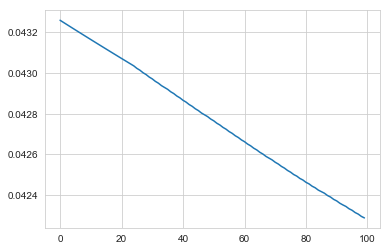

In [10]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

##### 2.2.3. Классификация

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


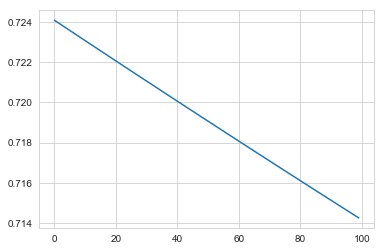

In [11]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.binomial(1, 0.5, size=100)

gb_test = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

### 3. Использование класса GradientBoosting

Проверим, как работает наш бустинг на двух задачах - регрессии и классификации на 2 класса.
Для этого будем использовать игрушечные выборки, полученные с помощью `sklearn.datasets.make_regression` и `sklearn.datasets.make_classificaiton`.

In [12]:
from sklearn.metrics import accuracy_score, mean_squared_error

#### 3.1. Задача регрессии

In [13]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [14]:
gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val, verbose=False)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


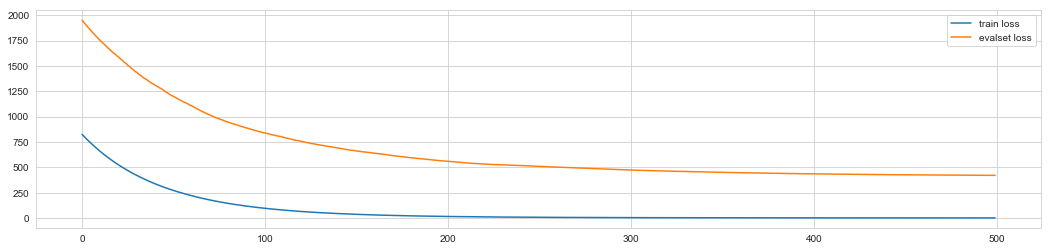

In [15]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "среднее по датасету" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций они должны отличаться как минимум в 100 раз.

*Код в ячейках ниже должен выполняться без ошибок.*

In [16]:
# Train
y_mean = np.mean(y_train) * np.ones_like(y_train)
mse_baseline = mean_squared_error(y_train, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_train)
mse_boosting = mean_squared_error(y_train, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 1648.606
MSE для предсказаний бустинга: 1.952


In [17]:
# Val
y_mean = np.mean(y_val) * np.ones_like(y_val)
mse_baseline = mean_squared_error(y_val, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_val)
mse_boosting = mean_squared_error(y_val, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 3)

MSE для предсказания среднего по выборке: 3531.394
MSE для предсказаний бустинга: 841.429


#### 3.2. Задача классификации

In [18]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [19]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=500, learning_rate=1.0, max_depth=3, task='class')
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


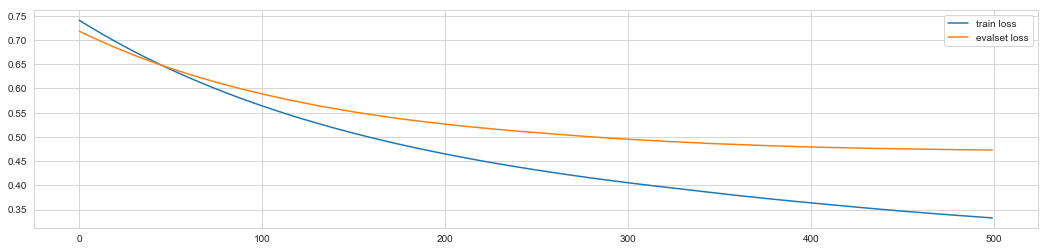

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.loss_values, label='train loss')
plt.plot(gb_classifier.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "подбрасывание монетки" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций ошибка бустинга должна быть как минимум вдвое меньше.

*Код в ячейках ниже должен выполняться без ошибок.*

In [21]:
# Train
y_random = np.random.binomial(1, 0.5, size=len(y_train))
accuracy_baseline = accuracy_score(y_train, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_train) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_train, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.537
Accuracy для предсказаний бустинга: 0.900


In [22]:
# Val
y_random = np.random.binomial(1, 0.5, size=len(y_val))
accuracy_baseline = accuracy_score(y_val, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_val) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_val, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.400
Accuracy для предсказаний бустинга: 0.850


Если все тесты пройдены успешно, попробуйте реализовать дополнительный функционал для вашего класса:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

Для того, чтобы дополнительные баллы были засчитаны, необходимо реализовать функционал и продемонстрировать результат в ячейке внизу.

In [23]:
# Probably, your code here

### Проверка работы критерия ранней остановки
#### early_stopping_rounds - сколько раз подряд ошибка на eval должна неуменьшаться чтобы прервать обучение
#### сделаем learning_rate =0, чтобы алгоритм не уменьшал ошибку
X_evalset y_evalset сделаем равными X_train y_train

In [24]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=500, learning_rate=0, max_depth=3, task='class')
gb_classifier.fit(X_train, y_train, X_evalset=X_train, y_evalset=y_train, verbose=True)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Iter # 10: Loss value: 0.7407489459974548
Loss on evalset: 0.7407489459974548
Iter # 20: Loss value: 0.7407489459974548
Loss on evalset: 0.7407489459974548


как видно, алгоритм остановился после 25 итераций (ошибка пишется на каждой 10 итерации)

## Часть 2. Решение задачи предсказания цены футболиста в FIFA 18 Ultimate Team

Нужно обучить какой-либо из рассмотренных в курсе ансамблей предсказывать трансферную стоимость футболиста из FIFA 18 Ultimate Team. Решение будет оцениваться по метрике MSE на тестовой выборке. Засчитывается только решение, качество которого на тестовой выборке окажется выше, чем у бейзлайна (см. в конце ноутбука).

Данные для обучения - `train_with_targets.csv`, столбец с целевой переменной - `price_ps4`.
Для отправки решения заполните столбец `price_ps4` в файле `test_submission.csv` предсказаниями своей модели на признаках из файла `test.csv` (убедитесь, что порядок следования `player_id` верный).

Для обучения моделей следует использовать:
* \*Свой класс для градиентного бустинга, реализованный выше
* Любые ансамбли из `sklearn` (`RandomForestRegressor`, `GradientBoostingRegressor`, ...)
* Любые фреймворки для градиентного бустинга (`XGBoost`, `LightGBM`, `CatBoost`, ...)
* \*Стекинг/блендинг (свой или тот, что был реализован на лекциях)
* Подбор гиперпараметров с помощью `RandomizedSearch` / `hyperopt` / ... 

Использование пунктов со звездочкой может накинуть дополнительных баллов за задание (по 1 баллу за пункт, т.е. максимум 2 дополнительных балла).

Удачи!

*Ниже приведен пример бейзлайна на случайном лесе из `sklearn`.*

### Baseline на RandomForestClassifier из Sklearn.ensemble

In [25]:
import pandas as pd
data_train = pd.read_csv('train_with_targets.csv')
data_train.head()

,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,cam,cf,rf,lf,rw,lw,st,price_ps4,traits,specialties
0,20920,Sacko,Hadi Sacko,Silver - Rare,Normal,Transfers,68,UD Las Palmas,LaLiga Santander,France,...,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0,"Tries To Beat Defensive Line, Selfish, Dribble...",Speedster
1,2996,Koo Ja Ryong,Ja Ryong Koo,Silver - Rare,Normal,NaN,73,Suwon Samsung Bluewings,K LEAGUE Classic,Korea Republic,...,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0,Leadership,NaN
2,12998,Gipson,Ken Gipson,Bronze,Normal,NaN,60,SV Sandhausen,Bundesliga 2,Germany,...,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0,NaN,NaN
3,16112,Yoda,Abdoul Karim Yoda,Silver,Normal,Transfers,69,CF Reus,LaLiga 1 I 2 I 3,France,...,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0,"Flair, Technical Dribbler",NaN
4,16502,Ronan,Connor Ronan,Bronze - Rare,Normal,Transfers,64,Portsmouth,EFL League One,Republic of Ireland,...,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0,NaN,NaN


In [26]:
data_train_num = data_train.select_dtypes(include=['int', 'float'])
data_train_num.fillna(data_train_num.mean(), inplace=True)
data_train_num.head()

C:\Users\miair\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,shooting,...,rm,lm,cam,cf,rf,lf,rw,lw,st,price_ps4
0,91.0,90.0,91.0,69.0,82.0,52.0,67.0,66.0,74.0,62.0,...,67.0,67.0,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0
1,72.0,69.0,74.0,49.0,67.0,64.0,66.0,55.0,36.0,29.0,...,48.0,48.0,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0
2,76.0,75.0,76.0,55.0,69.0,72.0,55.0,52.0,53.0,34.0,...,52.0,52.0,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0
3,84.0,79.0,88.0,73.0,74.0,62.0,55.0,74.0,77.0,61.0,...,68.0,68.0,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0
4,81.0,80.0,82.0,68.0,78.0,79.0,49.0,67.0,68.0,55.0,...,63.0,63.0,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0


In [27]:
from sklearn.model_selection import train_test_split as tts

X = data_train_num.drop(labels=['price_ps4'], axis=1).values[:, 1:]
y = data_train_num['price_ps4'].values
print(X.shape, y.shape)

X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18629, 55) (18629,)
(14903, 55) (14903,)
(3726, 55) (3726,)


In [28]:
X = data_train_num.drop(labels=['price_ps4'], axis=1).values[:, 1:]
y = data_train_num['price_ps4'].values
print(X.shape, y.shape)

(18629, 55) (18629,)


### Baseline

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

C:\Users\miair\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [30]:
rf_regressor_pred = rf_regressor.predict(X_train)
print('train MSE:', mean_squared_error(rf_regressor_pred, y_train))
rf_regressor_pred = rf_regressor.predict(X_val)
print('val MSE:', mean_squared_error(rf_regressor_pred, y_val))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


train MSE: 706029707.0127584


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


val MSE: 7474912458.630713


In [31]:
rf_regressor_pred = rf_regressor.predict(X_train)
print('train MSE:', mean_squared_error(rf_regressor_pred, y_train))
train_base = mean_squared_error(rf_regressor_pred, y_train)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


train MSE: 706029707.0127584


In [32]:
rf_regressor_pred = rf_regressor.predict(X_val)
print('val MSE:', mean_squared_error(rf_regressor_pred, y_val))
val_base=mean_squared_error(rf_regressor_pred, y_val)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


val MSE: 7474912458.630713


# Наш класс предсказание

In [33]:
our_gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=700, learning_rate=200, max_depth=3)
our_gb_regressor.fit(X_train, y_train, X_val, y_val, verbose=True)

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Iter # 10: Loss value: 4292268930.138732
Loss on evalset: 9386656779.547653
Iter # 20: Loss value: 3723711076.5365887
Loss on evalset: 8580624863.510104
Iter # 30: Loss value: 3266308661.4357443
Loss on evalset: 7862266044.216183
Iter # 40: Loss value: 2901658051.267243
Loss on evalset: 7178050784.201331
Iter # 50: Loss value: 2614919700.9369183
Loss on evalset: 6567064113.886177
Iter # 60: Loss value: 2383868319.4379616
Loss on evalset: 6216347379.488569
Iter # 70: Loss value: 2183906779.012676
Loss on evalset: 5858978802.794411
Iter # 80: Loss value: 1997067250.9998465
Loss on evalset: 5593932855.138953
Iter # 90: Loss value: 1845522008.0071123
Loss on evalset: 5372721053.406096
Iter # 100: Loss value: 1716828960.6765876
Loss on evalset: 5197853257.030893
Iter # 110: Loss value: 1610809089.8960576
Loss on evalset: 5035945493.334852
Iter # 120: Loss value: 1522216611.9278235
Loss on evalset: 4903303898.585912
Iter # 130: Loss value: 1434390052.54428
Loss on evalset: 4770607672.943209


In [34]:
our_predict_val = our_gb_regressor.predict(X_val)

значение mse от mse бейзлайна 

In [35]:
val_res=mean_squared_error(our_predict_val, y_val)
val_res/val_base

0.9994128386152182

# XGboost

In [38]:
import xgboost as xgb

In [39]:
bst = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=5)

In [40]:
%%time
bst.fit(X_train, y_train)

Wall time: 49.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [41]:
xgb_pred_val = bst.predict(X_val)

значение mse от mse бейзлайна 

In [42]:

val_res=mean_squared_error(xgb_pred_val, y_val)
print(val_res)
print(val_res/val_base)

5791715384.458487
0.7748204967633077


# Stacking

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
from sklearn.model_selection import KFold

In [45]:
class Stacking(object):
    
    def __init__(self, num_folds=3):   
        """
        Initialize Blending class.
        :param num_folds: number of folds to use for meta-features generating.
        """
        self.kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2)
        self.base_estimators = []
        self.meta_estimator = None
    
    def fit(self, base_estimators, meta_estimator, X, y):
        """
        Run training process for base models and for meta-model after.
        :param base_estimators: list of estimator instances (must have .fit() and .predict_proba() methods)
        :param meta_estimator: estimator instance for meta-model (must have .fit() and .predict_proba() methods)
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets 
        """
        self.base_estimators = base_estimators
        self.meta_estimator = meta_estimator
        
        meta_features = []
        meta_labels = []
        
        # For each fold train all base models on other num_folds-1 folds and generate meta-features for it
        folds = self.kfold.split(X)
        for train_idxs, pred_idxs in folds:
            X_train = X[train_idxs]
            y_train = y[train_idxs]
            X_pred = X[pred_idxs]
            y_pred = y[pred_idxs]
            meta_labels.append(y_pred)
            
            fold_predictions = []
            for estimator in self.base_estimators:
                estimator.fit(X_train, y_train)
                fold_predictions.append(estimator.predict(X_pred))
            meta_features.append(np.asarray(fold_predictions).T.reshape(X_pred.shape[0], -1))
        
        # Collect all generated meta-features and labels for them
        meta_features = np.concatenate(meta_features)
        meta_labels = np.concatenate(meta_labels)
        
        # Re-fit all base models on the whole dataset
        for estimator in self.base_estimators:
            estimator.fit(X, y)
        
        # Fit the meta-model on meta-features of A
        self.meta_estimator.fit(meta_features, meta_labels)

    
    def predict(self, X):
        meta_features = []
        
        # Generate meta-features of X (C) using base models 
        for estimator in self.base_estimators:
            meta_features.append(estimator.predict(X))
        meta_features = np.asarray(meta_features).T.reshape(X.shape[0], -1)
        
        # Predict targets for meta-features of X (C) using meta-model
        return self.meta_estimator.predict(meta_features)

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
from catboost import CatBoostRegressor

## Обучим стэккинг
#### Базовые модели - RandomForestRegressor, XGboostRegressor, sklearn GradientBoostingRegressor, CatBoostRegressor и наш класс градиентного бустинга. 

In [48]:
%%time
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)
bst = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=5)
skl_gb = GradientBoostingRegressor(subsample=0.5)
ctb = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.5, loss_function='RMSE')
our = GradientBoosting(loss=MSELoss(), n_estimators=700, learning_rate=200, max_depth=3)


stacker = Stacking(8)
reg_meta = LinearRegression()
stacker.fit(base_estimators=(rf_regressor, bst, skl_gb, ctb, our), meta_estimator=reg_meta, 
            X=X_train, y=y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 92906.3803398	total: 74.8ms	remaining: 7.41s
1:	learn: 79340.0524297	total: 102ms	remaining: 4.99s
2:	learn: 75044.2603969	total: 126ms	remaining: 4.06s
3:	learn: 73154.5912696	total: 150ms	remaining: 3.61s
4:	learn: 72212.2612342	total: 180ms	remaining: 3.42s
5:	learn: 71613.4834756	total: 208ms	remaining: 3.25s
6:	learn: 71119.4276054	total: 235ms	remaining: 3.12s
7:	learn: 67322.5338192	total: 268ms	remaining: 3.08s
8:	learn: 65206.1963606	total: 296ms	remaining: 2.99s
9:	learn: 63920.5545920	total: 330ms	remaining: 2.97s
10:	learn: 63355.3473070	total: 358ms	remaining: 2.89s
11:	learn: 62368.6066362	total: 389ms	remaining: 2.85s
12:	learn: 60407.0232605	total: 420ms	remaining: 2.81s
13:	learn: 60323.4351298	total: 449ms	remaining: 2.76s
14:	learn: 60218.0030359	total: 482ms	remaining: 2.73s
15:	learn: 56523.9523510	total: 516ms	remaining: 2.71s
16:	learn: 56205.1157878	total: 550ms	remaining: 2.68s
17:	learn: 55293.4395650	total: 581ms	remaining: 2.65s
18:	learn: 53830.36

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 83134.7857396	total: 25.4ms	remaining: 2.52s
1:	learn: 70849.7058564	total: 52.2ms	remaining: 2.56s
2:	learn: 64438.8229957	total: 88.6ms	remaining: 2.86s
3:	learn: 60144.1736608	total: 120ms	remaining: 2.89s
4:	learn: 58582.6833971	total: 151ms	remaining: 2.87s
5:	learn: 56668.6484386	total: 184ms	remaining: 2.88s
6:	learn: 53725.6101270	total: 217ms	remaining: 2.88s
7:	learn: 53420.3881803	total: 249ms	remaining: 2.87s
8:	learn: 53151.0858538	total: 282ms	remaining: 2.85s
9:	learn: 52640.5681335	total: 312ms	remaining: 2.81s
10:	learn: 52134.6453396	total: 352ms	remaining: 2.84s
11:	learn: 51907.2296801	total: 388ms	remaining: 2.84s
12:	learn: 51274.6977295	total: 423ms	remaining: 2.83s
13:	learn: 51249.2790480	total: 457ms	remaining: 2.81s
14:	learn: 51248.2072016	total: 486ms	remaining: 2.75s
15:	learn: 51121.0812723	total: 520ms	remaining: 2.73s
16:	learn: 50969.8494699	total: 554ms	remaining: 2.7s
17:	learn: 50769.8596154	total: 586ms	remaining: 2.67s
18:	learn: 50394.5

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 79163.8417154	total: 27.2ms	remaining: 2.7s
1:	learn: 68553.2456221	total: 56.6ms	remaining: 2.77s
2:	learn: 60995.1985707	total: 91.8ms	remaining: 2.97s
3:	learn: 55656.1278651	total: 125ms	remaining: 2.99s
4:	learn: 53736.5759654	total: 156ms	remaining: 2.96s
5:	learn: 51887.0293195	total: 186ms	remaining: 2.91s
6:	learn: 49665.9393463	total: 217ms	remaining: 2.88s
7:	learn: 47902.1231649	total: 255ms	remaining: 2.94s
8:	learn: 47307.5306663	total: 289ms	remaining: 2.92s
9:	learn: 46401.0946851	total: 325ms	remaining: 2.93s
10:	learn: 44852.2967417	total: 356ms	remaining: 2.88s
11:	learn: 43461.6769986	total: 389ms	remaining: 2.85s
12:	learn: 42950.4826599	total: 423ms	remaining: 2.83s
13:	learn: 42427.8983754	total: 455ms	remaining: 2.8s
14:	learn: 42144.9574712	total: 492ms	remaining: 2.79s
15:	learn: 40119.4627400	total: 529ms	remaining: 2.78s
16:	learn: 40072.3917691	total: 563ms	remaining: 2.75s
17:	learn: 38921.6361592	total: 598ms	remaining: 2.73s
18:	learn: 38679.61

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 89688.8615940	total: 28.2ms	remaining: 2.79s
1:	learn: 73986.1131312	total: 53.8ms	remaining: 2.64s
2:	learn: 69464.2254868	total: 87.1ms	remaining: 2.81s
3:	learn: 63337.7831712	total: 115ms	remaining: 2.76s
4:	learn: 61343.2845710	total: 146ms	remaining: 2.77s
5:	learn: 60163.9832552	total: 173ms	remaining: 2.71s
6:	learn: 55786.3850713	total: 202ms	remaining: 2.69s
7:	learn: 53702.1814194	total: 235ms	remaining: 2.71s
8:	learn: 51111.3147382	total: 264ms	remaining: 2.67s
9:	learn: 51028.1004952	total: 295ms	remaining: 2.66s
10:	learn: 50325.1612213	total: 328ms	remaining: 2.66s
11:	learn: 49462.6193782	total: 364ms	remaining: 2.67s
12:	learn: 48971.0337882	total: 398ms	remaining: 2.67s
13:	learn: 47470.6331010	total: 431ms	remaining: 2.65s
14:	learn: 47125.8733135	total: 462ms	remaining: 2.62s
15:	learn: 46792.5350157	total: 494ms	remaining: 2.59s
16:	learn: 45569.0294341	total: 523ms	remaining: 2.55s
17:	learn: 45519.7477396	total: 557ms	remaining: 2.54s
18:	learn: 45129.

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 85464.3561569	total: 33.2ms	remaining: 3.28s
1:	learn: 77015.4434786	total: 59.6ms	remaining: 2.92s
2:	learn: 69138.1831490	total: 84.7ms	remaining: 2.74s
3:	learn: 65284.8759807	total: 109ms	remaining: 2.62s
4:	learn: 63703.2380462	total: 135ms	remaining: 2.57s
5:	learn: 61462.2470352	total: 165ms	remaining: 2.58s
6:	learn: 60763.1880350	total: 191ms	remaining: 2.54s
7:	learn: 60667.3616472	total: 220ms	remaining: 2.53s
8:	learn: 59885.0552088	total: 253ms	remaining: 2.55s
9:	learn: 59440.5596980	total: 282ms	remaining: 2.54s
10:	learn: 58264.2462379	total: 308ms	remaining: 2.49s
11:	learn: 58089.0931520	total: 334ms	remaining: 2.45s
12:	learn: 57886.3955123	total: 360ms	remaining: 2.41s
13:	learn: 57286.2391925	total: 386ms	remaining: 2.37s
14:	learn: 57282.9062429	total: 412ms	remaining: 2.33s
15:	learn: 57017.0432876	total: 438ms	remaining: 2.3s
16:	learn: 56766.4962189	total: 466ms	remaining: 2.27s
17:	learn: 56664.5767865	total: 491ms	remaining: 2.24s
18:	learn: 56279.1

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 82597.3141820	total: 27.4ms	remaining: 2.71s
1:	learn: 74028.9762862	total: 52.7ms	remaining: 2.58s
2:	learn: 69498.3063312	total: 79ms	remaining: 2.55s
3:	learn: 63278.7878073	total: 106ms	remaining: 2.53s
4:	learn: 62156.1959782	total: 131ms	remaining: 2.49s
5:	learn: 61025.6413602	total: 157ms	remaining: 2.47s
6:	learn: 58767.8325397	total: 183ms	remaining: 2.44s
7:	learn: 57916.9646644	total: 209ms	remaining: 2.4s
8:	learn: 57588.1510977	total: 234ms	remaining: 2.37s
9:	learn: 57395.7728189	total: 260ms	remaining: 2.34s
10:	learn: 57379.2494263	total: 286ms	remaining: 2.31s
11:	learn: 57279.7685624	total: 313ms	remaining: 2.3s
12:	learn: 57206.3581323	total: 340ms	remaining: 2.27s
13:	learn: 55749.5430815	total: 366ms	remaining: 2.25s
14:	learn: 54632.4431633	total: 396ms	remaining: 2.25s
15:	learn: 52834.2261352	total: 423ms	remaining: 2.22s
16:	learn: 52447.1678608	total: 458ms	remaining: 2.23s
17:	learn: 52019.1011573	total: 489ms	remaining: 2.23s
18:	learn: 51832.4681

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 77328.7482363	total: 26.8ms	remaining: 2.65s
1:	learn: 68645.0628431	total: 50.5ms	remaining: 2.47s
2:	learn: 65842.3217307	total: 74.7ms	remaining: 2.42s
3:	learn: 62317.2805294	total: 102ms	remaining: 2.44s
4:	learn: 61597.6641206	total: 132ms	remaining: 2.5s
5:	learn: 60758.2392111	total: 163ms	remaining: 2.55s
6:	learn: 59400.7071565	total: 189ms	remaining: 2.51s
7:	learn: 54429.8147992	total: 214ms	remaining: 2.46s
8:	learn: 54088.2165722	total: 242ms	remaining: 2.44s
9:	learn: 49292.9713647	total: 267ms	remaining: 2.4s
10:	learn: 48265.8161687	total: 292ms	remaining: 2.36s
11:	learn: 47233.1579055	total: 317ms	remaining: 2.33s
12:	learn: 47128.4490342	total: 344ms	remaining: 2.3s
13:	learn: 46862.8604748	total: 368ms	remaining: 2.26s
14:	learn: 46103.3245070	total: 394ms	remaining: 2.23s
15:	learn: 45818.6135800	total: 421ms	remaining: 2.21s
16:	learn: 45393.5756622	total: 447ms	remaining: 2.18s
17:	learn: 44122.2046033	total: 474ms	remaining: 2.16s
18:	learn: 43884.260

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 77376.0431957	total: 31.5ms	remaining: 3.12s
1:	learn: 66572.4240910	total: 56.7ms	remaining: 2.78s
2:	learn: 62083.6605497	total: 82.2ms	remaining: 2.66s
3:	learn: 58890.1522989	total: 108ms	remaining: 2.58s
4:	learn: 55570.9937384	total: 134ms	remaining: 2.54s
5:	learn: 54089.1660419	total: 160ms	remaining: 2.51s
6:	learn: 53051.7409345	total: 185ms	remaining: 2.46s
7:	learn: 49657.2221224	total: 213ms	remaining: 2.45s
8:	learn: 48468.3069653	total: 238ms	remaining: 2.41s
9:	learn: 46742.9196895	total: 266ms	remaining: 2.4s
10:	learn: 46727.6065675	total: 292ms	remaining: 2.36s
11:	learn: 45340.6538510	total: 318ms	remaining: 2.33s
12:	learn: 45167.8264542	total: 350ms	remaining: 2.34s
13:	learn: 45057.7198340	total: 383ms	remaining: 2.35s
14:	learn: 43785.8252772	total: 416ms	remaining: 2.35s
15:	learn: 43740.6133805	total: 442ms	remaining: 2.32s
16:	learn: 43635.9971929	total: 468ms	remaining: 2.29s
17:	learn: 43402.4357943	total: 495ms	remaining: 2.25s
18:	learn: 43350.4

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


0:	learn: 80091.6576492	total: 27.5ms	remaining: 2.72s
1:	learn: 69795.7193209	total: 51.7ms	remaining: 2.53s
2:	learn: 67294.2496941	total: 76.8ms	remaining: 2.48s
3:	learn: 65563.3857793	total: 101ms	remaining: 2.43s
4:	learn: 64797.2068824	total: 126ms	remaining: 2.38s
5:	learn: 60196.3346332	total: 150ms	remaining: 2.35s
6:	learn: 57819.5078955	total: 177ms	remaining: 2.35s
7:	learn: 57024.4544648	total: 201ms	remaining: 2.31s
8:	learn: 53880.9956242	total: 227ms	remaining: 2.29s
9:	learn: 53222.2244309	total: 252ms	remaining: 2.27s
10:	learn: 51330.5254574	total: 280ms	remaining: 2.26s
11:	learn: 49648.3116961	total: 307ms	remaining: 2.25s
12:	learn: 49600.8365630	total: 332ms	remaining: 2.22s
13:	learn: 49356.3504767	total: 356ms	remaining: 2.19s
14:	learn: 49233.1281263	total: 385ms	remaining: 2.18s
15:	learn: 49232.5886193	total: 411ms	remaining: 2.16s
16:	learn: 49037.7991394	total: 437ms	remaining: 2.13s
17:	learn: 48185.1147589	total: 465ms	remaining: 2.12s
18:	learn: 46662.

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Wall time: 15min 56s


##### значение mse на valid
##### значение mse бейзлайна
###### значение mse от mse бейзлайна на valid

In [49]:
val_res=mean_squared_error(stacker.predict(X_val), y_val)
print(val_res)
print(val_base)
print(val_res/val_base)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


5462968198.835505
7474912458.630713
0.7308404250979328


## Обучим стэккинг на всей выборке 19m 21s

In [50]:
%%time
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)
bst = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=5)
skl_gb = GradientBoostingRegressor(subsample=0.5)
ctb = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.5, loss_function='RMSE')
our = GradientBoosting(loss=MSELoss(), n_estimators=700, learning_rate=200, max_depth=3)


stacker_all = Stacking(8)
reg_meta = LinearRegression()
stacker_all.fit(base_estimators=(rf_regressor, bst, skl_gb, ctb, our), meta_estimator=reg_meta, 
            X=X, y=y)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 79702.0471412	total: 30.3ms	remaining: 3s
1:	learn: 68289.6249206	total: 56.6ms	remaining: 2.77s
2:	learn: 63675.3623413	total: 82ms	remaining: 2.65s
3:	learn: 62176.8948577	total: 108ms	remaining: 2.59s
4:	learn: 58953.0437825	total: 136ms	remaining: 2.59s
5:	learn: 58797.9743589	total: 162ms	remaining: 2.54s
6:	learn: 58228.9385975	total: 189ms	remaining: 2.5s
7:	learn: 57452.7090376	total: 214ms	remaining: 2.46s
8:	learn: 57152.6054300	total: 242ms	remaining: 2.44s
9:	learn: 57023.6387805	total: 268ms	remaining: 2.41s
10:	learn: 54054.8540254	total: 295ms	remaining: 2.38s
11:	learn: 53646.8743021	total: 323ms	remaining: 2.37s
12:	learn: 53013.3475370	total: 351ms	remaining: 2.35s
13:	learn: 52709.6221237	total: 378ms	remaining: 2.32s
14:	learn: 52201.5355661	total: 405ms	remaining: 2.3s
15:	learn: 50786.5065724	total: 435ms	remaining: 2.28s
16:	learn: 50704.2545356	total: 461ms	remaining: 2.25s
17:	learn: 50380.2148042	total: 490ms	remaining: 2.23s
18:	learn: 50214.1132932

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 92906.7296407	total: 27.4ms	remaining: 2.71s
1:	learn: 81107.8100361	total: 54ms	remaining: 2.64s
2:	learn: 75709.8733128	total: 78.5ms	remaining: 2.54s
3:	learn: 71009.0146864	total: 104ms	remaining: 2.5s
4:	learn: 67215.9744673	total: 129ms	remaining: 2.46s
5:	learn: 64586.4434032	total: 155ms	remaining: 2.42s
6:	learn: 63323.4467110	total: 181ms	remaining: 2.4s
7:	learn: 61860.1002880	total: 209ms	remaining: 2.4s
8:	learn: 61243.6624548	total: 236ms	remaining: 2.38s
9:	learn: 60564.1790783	total: 262ms	remaining: 2.36s
10:	learn: 60194.6233256	total: 289ms	remaining: 2.33s
11:	learn: 59708.3280556	total: 313ms	remaining: 2.3s
12:	learn: 59539.0385169	total: 342ms	remaining: 2.29s
13:	learn: 59440.0975123	total: 368ms	remaining: 2.26s
14:	learn: 58731.6293291	total: 397ms	remaining: 2.25s
15:	learn: 58335.4285477	total: 422ms	remaining: 2.22s
16:	learn: 57795.7647838	total: 449ms	remaining: 2.19s
17:	learn: 57065.3803259	total: 477ms	remaining: 2.17s
18:	learn: 55495.848293

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 93157.9460016	total: 39ms	remaining: 3.86s
1:	learn: 80237.5476194	total: 69.4ms	remaining: 3.4s
2:	learn: 71928.1492460	total: 100ms	remaining: 3.23s
3:	learn: 67399.2089667	total: 131ms	remaining: 3.15s
4:	learn: 65199.9083660	total: 162ms	remaining: 3.08s
5:	learn: 61910.0799448	total: 194ms	remaining: 3.04s
6:	learn: 60904.5546426	total: 226ms	remaining: 3s
7:	learn: 59709.4785468	total: 252ms	remaining: 2.9s
8:	learn: 58557.6798394	total: 279ms	remaining: 2.82s
9:	learn: 57833.1198249	total: 307ms	remaining: 2.76s
10:	learn: 56390.6922065	total: 334ms	remaining: 2.7s
11:	learn: 55772.2151149	total: 362ms	remaining: 2.65s
12:	learn: 55595.5450385	total: 389ms	remaining: 2.61s
13:	learn: 55481.7983368	total: 416ms	remaining: 2.56s
14:	learn: 55391.5877175	total: 442ms	remaining: 2.5s
15:	learn: 55289.1017737	total: 470ms	remaining: 2.47s
16:	learn: 55169.0349929	total: 499ms	remaining: 2.44s
17:	learn: 54352.5212060	total: 531ms	remaining: 2.42s
18:	learn: 53727.8210839	to

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 97137.3549478	total: 28.1ms	remaining: 2.78s
1:	learn: 79150.8716100	total: 52.1ms	remaining: 2.55s
2:	learn: 69722.1283783	total: 76.4ms	remaining: 2.47s
3:	learn: 64392.9145576	total: 101ms	remaining: 2.43s
4:	learn: 59563.7443067	total: 127ms	remaining: 2.42s
5:	learn: 56318.7403492	total: 152ms	remaining: 2.38s
6:	learn: 54090.9496940	total: 177ms	remaining: 2.35s
7:	learn: 53831.1041203	total: 206ms	remaining: 2.37s
8:	learn: 53570.2820606	total: 232ms	remaining: 2.35s
9:	learn: 53288.9462954	total: 258ms	remaining: 2.32s
10:	learn: 53141.0253460	total: 284ms	remaining: 2.29s
11:	learn: 50913.3407903	total: 310ms	remaining: 2.27s
12:	learn: 50881.6346801	total: 336ms	remaining: 2.25s
13:	learn: 49561.8604264	total: 362ms	remaining: 2.22s
14:	learn: 48892.1598826	total: 388ms	remaining: 2.2s
15:	learn: 48326.7282453	total: 415ms	remaining: 2.18s
16:	learn: 48310.3786265	total: 443ms	remaining: 2.16s
17:	learn: 47900.6023395	total: 468ms	remaining: 2.13s
18:	learn: 47876.3

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 84610.7632538	total: 27.9ms	remaining: 2.76s
1:	learn: 73048.6847616	total: 53.1ms	remaining: 2.6s
2:	learn: 67511.5991296	total: 77.9ms	remaining: 2.52s
3:	learn: 59678.4636581	total: 105ms	remaining: 2.52s
4:	learn: 54794.0029014	total: 135ms	remaining: 2.56s
5:	learn: 52805.2049012	total: 160ms	remaining: 2.51s
6:	learn: 51236.4995312	total: 186ms	remaining: 2.48s
7:	learn: 49198.7372179	total: 211ms	remaining: 2.43s
8:	learn: 49111.3945828	total: 238ms	remaining: 2.4s
9:	learn: 49094.1286192	total: 266ms	remaining: 2.39s
10:	learn: 48974.2107115	total: 292ms	remaining: 2.37s
11:	learn: 48969.2684646	total: 318ms	remaining: 2.33s
12:	learn: 48478.2873775	total: 346ms	remaining: 2.31s
13:	learn: 46776.3268397	total: 374ms	remaining: 2.3s
14:	learn: 46435.7023847	total: 402ms	remaining: 2.28s
15:	learn: 45751.2790258	total: 429ms	remaining: 2.25s
16:	learn: 45630.6890758	total: 455ms	remaining: 2.22s
17:	learn: 45607.0025794	total: 484ms	remaining: 2.21s
18:	learn: 45592.139

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 85620.0968716	total: 29.3ms	remaining: 2.9s
1:	learn: 75533.3915625	total: 54.5ms	remaining: 2.67s
2:	learn: 71046.4456428	total: 79.5ms	remaining: 2.57s
3:	learn: 66065.3162844	total: 108ms	remaining: 2.6s
4:	learn: 59998.2320095	total: 137ms	remaining: 2.6s
5:	learn: 56833.0791050	total: 163ms	remaining: 2.55s
6:	learn: 54364.7896405	total: 189ms	remaining: 2.51s
7:	learn: 53918.5292993	total: 216ms	remaining: 2.48s
8:	learn: 53048.4041827	total: 240ms	remaining: 2.43s
9:	learn: 52939.3547876	total: 267ms	remaining: 2.4s
10:	learn: 51699.2517305	total: 293ms	remaining: 2.37s
11:	learn: 50023.0996001	total: 319ms	remaining: 2.34s
12:	learn: 47567.2204148	total: 348ms	remaining: 2.33s
13:	learn: 47322.1669468	total: 374ms	remaining: 2.3s
14:	learn: 47032.7310893	total: 401ms	remaining: 2.27s
15:	learn: 46981.4761229	total: 429ms	remaining: 2.25s
16:	learn: 46557.0662493	total: 455ms	remaining: 2.22s
17:	learn: 46082.6295392	total: 483ms	remaining: 2.2s
18:	learn: 45830.262041

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 90649.6994861	total: 28.5ms	remaining: 2.82s
1:	learn: 77390.6402643	total: 55.5ms	remaining: 2.72s
2:	learn: 70819.2084598	total: 88ms	remaining: 2.84s
3:	learn: 67728.5006585	total: 119ms	remaining: 2.87s
4:	learn: 66433.9444602	total: 152ms	remaining: 2.89s
5:	learn: 65762.7609147	total: 182ms	remaining: 2.85s
6:	learn: 65198.0305191	total: 218ms	remaining: 2.9s
7:	learn: 59339.6448223	total: 252ms	remaining: 2.9s
8:	learn: 56240.3802396	total: 284ms	remaining: 2.87s
9:	learn: 53349.3337532	total: 320ms	remaining: 2.88s
10:	learn: 52658.1557732	total: 350ms	remaining: 2.83s
11:	learn: 52639.6704072	total: 385ms	remaining: 2.82s
12:	learn: 48409.8761013	total: 417ms	remaining: 2.79s
13:	learn: 47930.0610678	total: 451ms	remaining: 2.77s
14:	learn: 47240.0744303	total: 488ms	remaining: 2.77s
15:	learn: 45714.0622405	total: 527ms	remaining: 2.77s
16:	learn: 44635.8332824	total: 561ms	remaining: 2.74s
17:	learn: 44358.2397913	total: 599ms	remaining: 2.73s
18:	learn: 42138.2709

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0:	learn: 93745.0289593	total: 28.3ms	remaining: 2.81s
1:	learn: 82901.9719642	total: 55.8ms	remaining: 2.73s
2:	learn: 76373.5588066	total: 90.2ms	remaining: 2.92s
3:	learn: 74275.5116073	total: 121ms	remaining: 2.91s
4:	learn: 69451.8957562	total: 152ms	remaining: 2.89s
5:	learn: 66531.5886101	total: 185ms	remaining: 2.9s
6:	learn: 65000.0712186	total: 217ms	remaining: 2.88s
7:	learn: 64375.4742045	total: 250ms	remaining: 2.88s
8:	learn: 64059.1173917	total: 283ms	remaining: 2.87s
9:	learn: 62806.3536876	total: 319ms	remaining: 2.87s
10:	learn: 62509.7604074	total: 356ms	remaining: 2.88s
11:	learn: 62081.0454616	total: 400ms	remaining: 2.93s
12:	learn: 58323.8062040	total: 434ms	remaining: 2.91s
13:	learn: 58294.9750103	total: 471ms	remaining: 2.89s
14:	learn: 58251.4954356	total: 506ms	remaining: 2.87s
15:	learn: 56417.2757951	total: 544ms	remaining: 2.85s
16:	learn: 56302.7737800	total: 599ms	remaining: 2.92s
17:	learn: 56285.3534663	total: 636ms	remaining: 2.9s
18:	learn: 56034.81

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


0:	learn: 88087.0351502	total: 32.4ms	remaining: 3.21s
1:	learn: 77844.5560063	total: 62.7ms	remaining: 3.07s
2:	learn: 72839.8764724	total: 92.1ms	remaining: 2.98s
3:	learn: 66675.6934021	total: 120ms	remaining: 2.87s
4:	learn: 62851.9087576	total: 146ms	remaining: 2.77s
5:	learn: 61439.3074790	total: 176ms	remaining: 2.75s
6:	learn: 57185.7684072	total: 204ms	remaining: 2.71s
7:	learn: 55168.9045543	total: 231ms	remaining: 2.65s
8:	learn: 54847.3487429	total: 261ms	remaining: 2.64s
9:	learn: 54494.5979943	total: 289ms	remaining: 2.6s
10:	learn: 54373.4735560	total: 317ms	remaining: 2.56s
11:	learn: 54283.3116215	total: 345ms	remaining: 2.53s
12:	learn: 53828.3838353	total: 375ms	remaining: 2.51s
13:	learn: 52597.4778944	total: 404ms	remaining: 2.48s
14:	learn: 52481.4641907	total: 432ms	remaining: 2.45s
15:	learn: 52472.9150622	total: 460ms	remaining: 2.41s
16:	learn: 52469.1859647	total: 489ms	remaining: 2.38s
17:	learn: 52360.9966118	total: 517ms	remaining: 2.36s
18:	learn: 51832.6

C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
C:\Users\miair\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Wall time: 19min 21s


## Скачиваем данные для теста

In [130]:
import pandas as pd
data_test = pd.read_csv('test.csv')
data_test.head()



,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,lm,cam,cf,rf,lf,rw,lw,st,traits,specialties
0,9991,Pálsson,Victor Pálsson,Bronze - Rare,Normal,NaN,64,FC Zürich,Raiffeisen Super League,Iceland,...,60.0,60.0,59.0,59.0,59.0,58.0,58.0,60.0,Dives Into Tackles,NaN
1,13037,Palomeque,Ezequiel Palomeque,Bronze - Rare,Normal,NaN,60,Atlético Nacional,Liga Dimayor,Colombia,...,34.0,32.0,33.0,33.0,33.0,32.0,32.0,38.0,NaN,Strength
2,1254,Partey,Thomas Partey,Gold - Rare,Normal,NaN,77,Atlético Madrid,LaLiga Santander,Ghana,...,70.0,70.0,69.0,69.0,69.0,69.0,69.0,68.0,Dives Into Tackles,NaN
3,19697,Mirante,Antonio Mirante,Gold,Normal,Transfers,80,Roma,Calcio A,Italy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12390,Allen,Jordan Allen,Bronze,Normal,NaN,61,Real Salt Lake,Major League Soccer,United States,...,60.0,61.0,60.0,60.0,60.0,61.0,61.0,58.0,NaN,NaN


In [131]:
data_test_num = data_test.select_dtypes(include=['int', 'float'])
data_test_num.fillna(data_test_num.mean(), inplace=True)
data_test_num.head()

C:\Users\miair\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,shooting,...,cm,rm,lm,cam,cf,rf,lf,rw,lw,st
0,65.000000,61.0,69.0,60.000000,68.0,54.0,62.0,64.0,56.0,53.000000,...,63.000000,60.00000,60.00000,60.0000,59.000000,59.000000,59.000000,58.000000,58.000000,60.000000
1,52.000000,53.0,51.0,30.000000,33.0,33.0,48.0,33.0,25.0,25.000000,...,36.000000,34.00000,34.00000,32.0000,33.000000,33.000000,33.000000,32.000000,32.000000,38.000000
2,76.000000,73.0,78.0,72.000000,73.0,55.0,74.0,74.0,72.0,60.000000,...,73.000000,70.00000,70.00000,70.0000,69.000000,69.000000,69.000000,69.000000,69.000000,68.000000
3,69.752381,44.0,43.0,64.802801,50.0,50.0,77.0,21.0,15.0,55.272269,...,61.203029,62.71733,62.71733,62.0129,61.803141,61.803141,61.803141,62.048233,62.048233,60.967471
4,70.000000,64.0,75.0,65.000000,77.0,70.0,60.0,64.0,63.0,52.000000,...,60.000000,60.00000,60.00000,61.0000,60.000000,60.000000,60.000000,61.000000,61.000000,58.000000


In [132]:
X_test = data_test_num.values[:, 1:]

In [133]:
X_test.shape

(2000, 55)

## Делаем предсказание для теста

In [134]:
predict_test = stacker_all.predict(X_test)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [135]:
predict_pd = pd.DataFrame(predict_test, columns=['price_ps4'])

In [138]:
a = pd.DataFrame(data_test['player_ID'])

In [139]:
z = pd.concat([a, predict_pd['price_ps4']], axis=1, sort=False)

In [141]:
z.to_csv('test_submission.csv')

## Тестирование:

In [142]:
from sklearn.metrics import mean_squared_error 

In [147]:
my_submission = pd.read_csv('test_submission.csv')
true_submssion = pd.read_csv('test_submission.csv')

In [148]:
assert sum(my_submission['player_ID'].values != true_submssion['player_ID'].values) == 0

In [149]:
mse = mean_squared_error(my_submission['player_ID'], true_submssion['player_ID'])
print(mse)

0.0


### Ошибка на тестовом сете

In [150]:
print(mean_squared_error(true_submssion['price_ps4'], my_submission['price_ps4']))

0.0
